# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import copy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, multilabel_confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
data['Time'] = pd.to_datetime(data['Time'].values, format='%m/%d/%Y')
data = data.set_index('Time')
## Calculate % Change of Closing Price
#data['ret_final']=(data['Close'].shift(-1)-data['Close'])/data['Close']
data['ret_final'] = data.Close.pct_change()
data['ret_final'] = data.fillna(0)
#data['label'] = [(1 if j>0 else 0) for j in data.ret_final]
data['label_down_200'] = [0] + [(1  if (data.Close[i] < (0.98 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_175'] = [0] + [(1  if (data.Close[i] < (0.9825 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_150'] = [0] + [(1  if (data.Close[i] < (0.985 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_125'] = [0] + [(1  if (data.Close[i] < (0.9875 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_100'] = [0] + [(1  if (data.Close[i] < (0.99 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_75'] = [0] + [(1  if (data.Close[i] < (0.9925 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_50'] = [0] + [(1  if (data.Close[i] < (0.995 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_down_25'] = [0] + [(1  if (data.Close[i] < (0.9975 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_25'] = [0] + [(1  if (data.Close[i] > (1.0025 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_50'] = [0] + [(1  if (data.Close[i] > (1.005 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_75'] = [0] + [(1  if (data.Close[i] > (1.0075 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_100'] = [0] + [(1  if (data.Close[i] > (1.01 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_125'] = [0] + [(1  if (data.Close[i] > (1.0125 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_150'] = [0] + [(1  if (data.Close[i] > (1.015 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_175'] = [0] + [(1  if (data.Close[i] > (1.0175 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]
data['label_up_200'] = [0] + [(1  if (data.Close[i] > (1.02 * data.Close[i-1])) else 0) for i in range(1,len(data.Close))]

target_cols = ['label_down_200','label_down_175', 'label_down_150','label_down_125','label_down_100','label_down_75','label_down_50','label_down_25',\
  'label_up_25','label_up_50','label_up_75','label_up_100','label_up_125','label_up_150','label_up_175','label_up_200']

labels = []
for row in data[target_cols].values:
    l = []
    for i, val in enumerate(row):
        if val == 1:
            l.append(target_cols[i])
    labels.append(l)

data['labels'] = labels

data = data.fillna(0)
data.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,...,label_down_25,label_up_25,label_up_50,label_up_75,label_up_100,label_up_125,label_up_150,label_up_175,label_up_200,labels
Time,,,,,,,,,,,,,,,,,,,,,
2008-10-15,14.83,15.29,13.98,13.99,387619900,0.0,-0.641,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,[]
2008-10-16,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,0.0,...,0,1,1,1,1,1,1,1,1,"[label_up_25, label_up_50, label_up_75, label_..."
2008-10-17,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,"[label_down_200, label_down_175, label_down_15..."
2008-10-20,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,0.0,...,0,1,1,1,1,0,0,0,0,"[label_up_25, label_up_50, label_up_75, label_..."
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,"[label_down_200, label_down_175, label_down_15..."


In [3]:
print('Entries with more than 1 labels : ', sum([1 for val in data[['label_down_200','label_down_175', 'label_down_150','label_down_125','label_down_100','label_down_75','label_down_50','label_down_25',\
  'label_up_25','label_up_50','label_up_75','label_up_100','label_up_125','label_up_150','label_up_175','label_up_200']].values if sum(val) > 1]))

Entries with more than 1 labels :  1917


## Dividing Data Into Train/Test Sets

In [4]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
Y_one_hot = data[['label_down_200','label_down_175', 'label_down_150','label_down_125','label_down_100','label_down_75','label_down_50','label_down_25',\
  'label_up_25','label_up_50','label_up_75','label_up_100','label_up_125','label_up_150','label_up_175','label_up_200']].values

ret_vals = data['ret_final'].values

X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.9, test_size=0.1, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train_one_hot.shape, Y_test_one_hot.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

Train/Test Sizes :  (2480, 15) (276, 15) (2480, 16) (276, 16)
Actual Return Sizes :  (276,)


### Finance Metrics
Below are some of finance evaluation metrics

In [5]:
def WR(returns,predictions):
    total_trades = predictions.sum()
    wins= ((returns*predictions)>0).sum()
    return(wins/total_trades)

def ARR(returns,predictions):
    total_trades = predictions.sum()
    all_returns = returns*predictions
    total_return = all_returns.sum()
    gain=(total_return)/total_trades
    arr=((1+gain))**252-1
    useful_returns=[all_returns[j] for j in range(len(predictions)) if predictions[j]==1]
    sigma=np.std(np.array(useful_returns))
    asr=np.sqrt(252)*gain/sigma
    return([arr,asr])

def MDD(returns,predictions):
    all_returns= returns*predictions
    cum_vals=np.cumprod(all_returns+1)
    i = np.argmax(np.maximum.accumulate(cum_vals) - cum_vals) # end of the period
    j = np.argmax(cum_vals[:i]) # start of period
    mdd=(cum_vals[j]- cum_vals[i])/cum_vals[j]
    return(mdd)

### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [6]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, predictions)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.grid(None)
        plt.xticks(range(len(target_cols)), target_cols)
        plt.yticks(range(len(target_cols)), target_cols)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# DenseNet v1
Below dense model consist of 4 dense layers with dimensions 128, 64,32,1 respectively. For internal layers we have selected activation function as relu. Last layer has activation function as sigmoid because its classification problem.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
Total params: 12,912
Trainable params: 12,912
Non-trainable params: 0
_________________________________________________________________
None


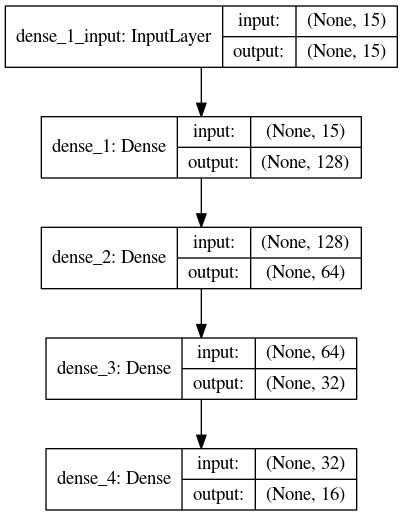

In [7]:
dense_model1 = Sequential([ Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(64,  activation='relu'),
                     Dense(32,  activation='relu'),
                     Dense(Y_train_one_hot.shape[1],   activation='sigmoid')])

print(dense_model1.summary())
plot_model(dense_model1, to_file='dense1.png', show_shapes=True)
Image.open('dense1.png')

## Compiling Model
Compiling Model involves setting optimizers to use, loss and evaluation metrics.

In [8]:
dense_model1.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model
Below we are fitting model with batch size of 4 for 25 epochs. We'll use 10% of train data as validation data for evaluation of performance during training.

In [9]:
history = dense_model1.fit(X_train, Y_train_one_hot, batch_size=8, epochs=25, validation_split=0.1, shuffle=False, use_multiprocessing=True);

Train on 2232 samples, validate on 248 samples
Epoch 1/25
2232/2232 [==============================] - 1s 409us/step - loss: 0.4863 - accuracy: 0.7624 - val_loss: 0.3782 - val_accuracy: 0.8352
Epoch 2/25
2232/2232 [==============================] - 1s 312us/step - loss: 0.4239 - accuracy: 0.8022 - val_loss: 0.3374 - val_accuracy: 0.8501
Epoch 3/25
2232/2232 [==============================] - 1s 237us/step - loss: 0.3868 - accuracy: 0.8209 - val_loss: 0.3092 - val_accuracy: 0.8606
Epoch 4/25
2232/2232 [==============================] - 1s 235us/step - loss: 0.3543 - accuracy: 0.8395 - val_loss: 0.2754 - val_accuracy: 0.8727
Epoch 5/25
2232/2232 [==============================] - 1s 231us/step - loss: 0.3317 - accuracy: 0.8509 - val_loss: 0.2685 - val_accuracy: 0.8705
Epoch 6/25
2232/2232 [==============================] - 1s 230us/step - loss: 0.3186 - accuracy: 0.8573 - val_loss: 0.2633 - val_accuracy: 0.8753
Epoch 7/25
2232/2232 [==============================] - 1s 229us/step - loss:

## Visualizing Training Stage Results

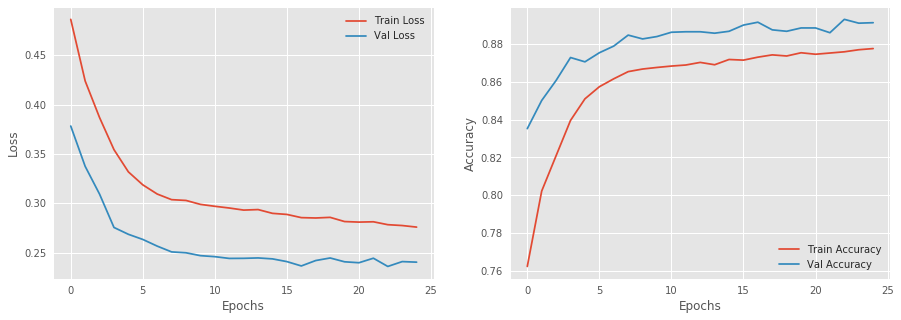

In [10]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [11]:
loss, acc = dense_model1.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

276/276 [==============================] - 0s 33us/step
Accuracy : 0.836


In [12]:
loss, acc = dense_model1.evaluate(X,Y_one_hot)
print('Accuracy : %.3f'%acc)

2756/2756 [==============================] - 0s 26us/step
Accuracy : 0.854


In [13]:
probs = dense_model1.predict_proba(X)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_cols[i])
    pred_labels.append(l)
    
df1 = copy.deepcopy(data)
df1['Preds'] = pred_labels
for i, col in enumerate(target_cols):
    df1[col + '_probs'] = probs[:,i]

## Printing/Plotting Classification Metrics

In [14]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    #wr_mlp, vals, mdd_mlp = WR(actual_rets_test,predictions), ARR(actual_rets_test,predictions), MDD(actual_rets_test,predictions)
    #arr_mlp, asr_mlp=vals[0], vals[1]
    #results.append([model_name, wr_mlp, arr_mlp, asr_mlp, mdd_mlp])

    #print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', multilabel_confusion_matrix(Y_test_one_hot, predictions))

predictions = dense_model1.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('DenseNetv1', actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[216  28]
  [  5  27]]

 [[206  30]
  [  7  33]]

 [[199  30]
  [  8  39]]

 [[190  35]
  [  3  48]]

 [[177  36]
  [  3  60]]

 [[149  48]
  [  4  75]]

 [[118  65]
  [  1  92]]

 [[ 74  92]
  [  1 109]]

 [[ 93  51]
  [ 11 121]]

 [[113  48]
  [  9 106]]

 [[140  42]
  [ 15  79]]

 [[176  24]
  [ 20  56]]

 [[199  19]
  [ 21  37]]

 [[208  20]
  [ 19  29]]

 [[223  15]
  [ 21  17]]

 [[238   8]
  [ 18  12]]]


## Visualising Weights
Below we are visualising average weights of first layer which has same shape as that of number of features.

Layer : Dense : Weights : (15, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 16)
Layer : Dense : Bias : (16,)


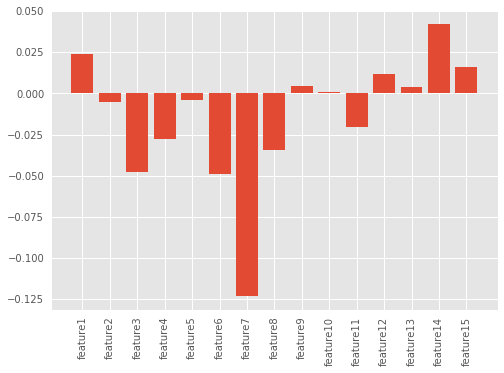

In [15]:
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

print_weights_per_layer(dense_model1)

dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# DenseNet v2
Below we have deisigned another dense net model which has 6 layers of shapes 512,256,128,64,32 and 1 respectively. We have used relu as activation function for internal layers and sigmoid for last layer. We also have used Dropout of 20% this time between each layer to see whether it help improve performance.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

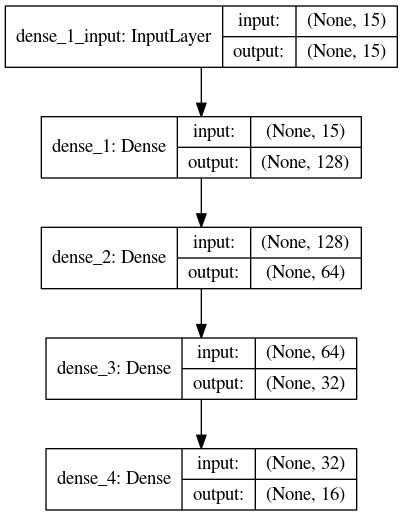

In [16]:
dense_model2 = Sequential([ 
                     Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.2),
                     Dense(256,  activation='relu'),
                     Dropout(0.2),
                     Dense(128,  activation='relu'),
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     Dropout(0.2),
                     Dense(Y_train_one_hot.shape[1],   activation='sigmoid')])

print(dense_model2.summary())
plot_model(dense_model1, to_file='dense2.png', show_shapes=True)
Image.open('dense2.png')

## Compiling Model

In [17]:
dense_model2.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model

In [18]:
history = dense_model2.fit(X_train, Y_train_one_hot, batch_size=8, epochs=25, validation_split=0.1, shuffle=False, use_multiprocessing=True);

Train on 2232 samples, validate on 248 samples
Epoch 1/25
2232/2232 [==============================] - 2s 760us/step - loss: 0.5706 - accuracy: 0.7102 - val_loss: 0.3978 - val_accuracy: 0.8284
Epoch 2/25
2232/2232 [==============================] - 1s 538us/step - loss: 0.4770 - accuracy: 0.7783 - val_loss: 0.3552 - val_accuracy: 0.8450
Epoch 3/25
2232/2232 [==============================] - 1s 544us/step - loss: 0.4429 - accuracy: 0.7954 - val_loss: 0.3193 - val_accuracy: 0.8574
Epoch 4/25
2232/2232 [==============================] - 1s 544us/step - loss: 0.4061 - accuracy: 0.8159 - val_loss: 0.2937 - val_accuracy: 0.8707
Epoch 5/25
2232/2232 [==============================] - 1s 598us/step - loss: 0.3795 - accuracy: 0.8281 - val_loss: 0.2795 - val_accuracy: 0.8770
Epoch 6/25
2232/2232 [==============================] - 1s 619us/step - loss: 0.3603 - accuracy: 0.8374 - val_loss: 0.2595 - val_accuracy: 0.8884
Epoch 7/25
2232/2232 [==============================] - 1s 613us/step - loss:

## Visualising Training Stage Results

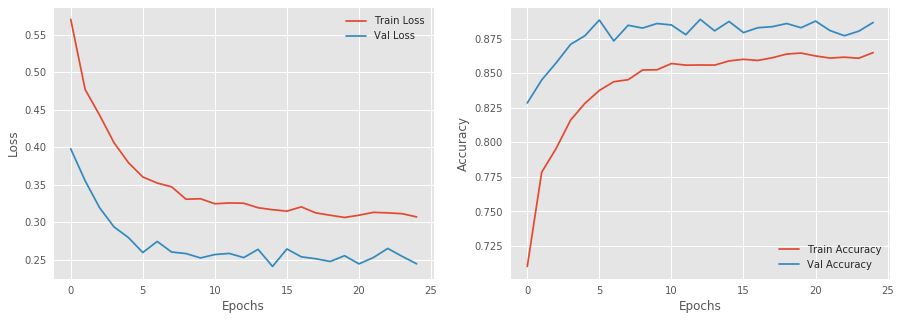

In [19]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [20]:
loss, acc = dense_model2.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

276/276 [==============================] - 0s 51us/step
Accuracy : 0.824


In [21]:
loss, acc = dense_model2.evaluate(X, Y_one_hot)
print('Accuracy : %.3f'%acc)

2756/2756 [==============================] - 0s 45us/step
Accuracy : 0.855


In [22]:
probs = dense_model2.predict_proba(X)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_cols[i])
    pred_labels.append(l)
    
df2 = copy.deepcopy(data)
df2['Preds'] = pred_labels
for i, col in enumerate(target_cols):
    df2[col + '_probs'] = probs[:,i]

## Printing/Plotting Classification Metrics

In [23]:
predictions = dense_model2.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('DenseNetv2', actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[226  18]
  [  8  24]]

 [[210  26]
  [  8  32]]

 [[196  33]
  [  9  38]]

 [[178  47]
  [  5  46]]

 [[161  52]
  [  4  59]]

 [[140  57]
  [  4  75]]

 [[ 96  87]
  [  1  92]]

 [[ 49 117]
  [  1 109]]

 [[ 69  75]
  [  6 126]]

 [[ 99  62]
  [  7 108]]

 [[134  48]
  [  9  85]]

 [[175  25]
  [ 17  59]]

 [[198  20]
  [ 20  38]]

 [[208  20]
  [ 21  27]]

 [[218  20]
  [ 15  23]]

 [[227  19]
  [  9  21]]]


Layer : Dense : Weights : (15, 512)
Layer : Dense : Bias : (512,)
Layer : Dense : Weights : (512, 256)
Layer : Dense : Bias : (256,)
Layer : Dense : Weights : (256, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 16)
Layer : Dense : Bias : (16,)


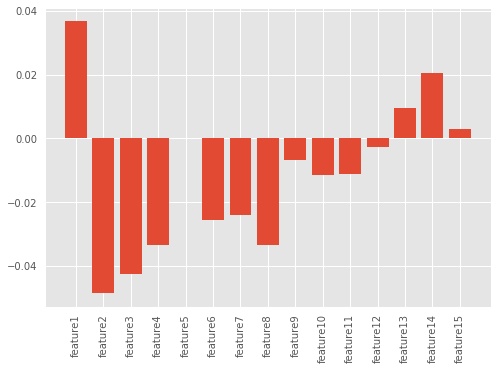

In [24]:
print_weights_per_layer(dense_model2)

dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v1

Below we are preparing data for LSTM. We are taking look back size of 50 so that we'll look at 50 previous sample to predict current one. We are organizing our dataset in that format so that it can be fed into LSTM.

In [25]:
def prepare_dataset(features,labels, look_back=1):
    X, Y = [], []
    for i in range(len(features)-look_back):
        a = features[i:(i+look_back), :]
        X.append(a)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
Y_one_hot = data[['label_down_200','label_down_175', 'label_down_150','label_down_125','label_down_100','label_down_75','label_down_50','label_down_25',\
  'label_up_25','label_up_50','label_up_75','label_up_100','label_up_125','label_up_150','label_up_175','label_up_200']].values

ret_vals = data['ret_final'].values

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Actual Return Sizes : ', actual_rets_test.shape)

# split into input and outputs
look_back = 50

X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.9, test_size=0.1, shuffle=False)

X_train, Y_train_one_hot = prepare_dataset(X_train, Y_train_one_hot, look_back)
X_test, Y_test_one_hot = prepare_dataset(X_test, Y_test_one_hot, look_back)

X_new, Y_new = prepare_dataset(X, Y_one_hot, look_back)
print('Modified Data Size : ', X_new.shape, Y_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train_one_hot.shape, X_test.shape, Y_test_one_hot.shape)

Actual Return Sizes :  (276,)
Modified Data Size :  (2706, 50, 15) (2706, 16)
Train/Test Sizes Modified (2430, 50, 15) (2430, 16) (226, 50, 15) (226, 16)


Below we have defined LSTM network of only 50 units. This parameter can be tweaked to check whether it improves performance further in future. My guess is that if we increase its value further then it'll performance. Output layer is again sigmoid.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                816       
Total params: 14,016
Trainable params: 14,016
Non-trainable params: 0
_________________________________________________________________
None


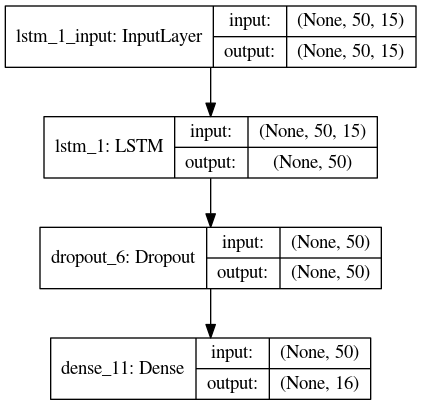

In [26]:
lstm_classif = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.2),
                        Dense(Y_train_one_hot.shape[1], activation='sigmoid')                        
                        ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif1.png', show_shapes=True)
Image.open('lstm_classif1.png')

## Compiling Model

In [27]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [28]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=8, validation_data=(X_test, Y_test_one_hot), verbose=1, shuffle=False)

Train on 2430 samples, validate on 226 samples
Epoch 1/30
2430/2430 [==============================] - 8s 3ms/step - loss: 0.5232 - accuracy: 0.7497 - val_loss: 0.5293 - val_accuracy: 0.7528
Epoch 2/30
2430/2430 [==============================] - 8s 3ms/step - loss: 0.4990 - accuracy: 0.7725 - val_loss: 0.5301 - val_accuracy: 0.7522
Epoch 3/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.4948 - accuracy: 0.7762 - val_loss: 0.5282 - val_accuracy: 0.7533
Epoch 4/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.4927 - accuracy: 0.7763 - val_loss: 0.5293 - val_accuracy: 0.7530
Epoch 5/30
2430/2430 [==============================] - 8s 3ms/step - loss: 0.4915 - accuracy: 0.7776 - val_loss: 0.5269 - val_accuracy: 0.7533
Epoch 6/30
2430/2430 [==============================] - 8s 3ms/step - loss: 0.4892 - accuracy: 0.7771 - val_loss: 0.5276 - val_accuracy: 0.7533
Epoch 7/30
2430/2430 [==============================] - 7s 3ms/step - loss: 0.4895 - accu

## Visualizing Training Stage Results

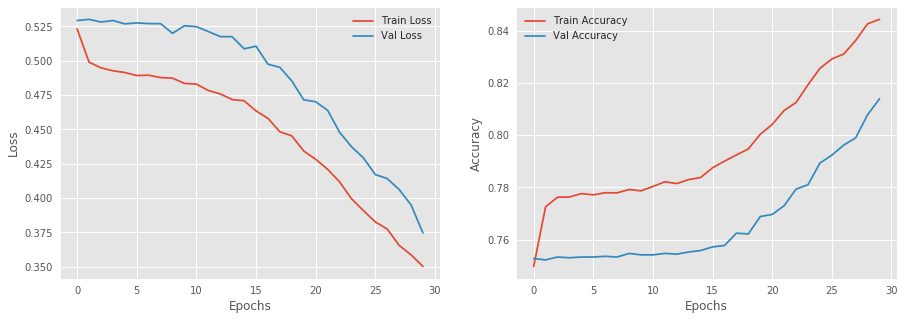

In [29]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [30]:
loss, acc = lstm_classif.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

226/226 [==============================] - 0s 286us/step
Accuracy : 0.814


In [31]:
loss, acc = lstm_classif.evaluate(X_new, Y_new)
print('Accuracy : %.3f'%acc)

2706/2706 [==============================] - 1s 236us/step
Accuracy : 0.839


In [32]:
probs = lstm_classif.predict_proba(X_new)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_cols[i])
    pred_labels.append(l)
    
df3 = copy.deepcopy(data)
df3['Preds'] = np.hstack((['label_down_200']*50, pred_labels))
for i, col in enumerate(target_cols):
    df3[col + '_probs'] = np.hstack((np.zeros(50), probs[:,i]))

## Printing/Plotting Classification Metrics

In [33]:
predictions = lstm_classif.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('LSTMv1', actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[184  15]
  [  7  20]]

 [[158  35]
  [  5  28]]

 [[154  35]
  [  1  36]]

 [[126  60]
  [  1  39]]

 [[100  77]
  [  0  49]]

 [[ 74  90]
  [  0  62]]

 [[ 34 117]
  [  0  75]]

 [[  8 127]
  [  0  91]]

 [[  5 115]
  [  0 106]]

 [[ 11 122]
  [  0  93]]

 [[ 18 133]
  [  0  75]]

 [[ 41 122]
  [  0  63]]

 [[ 77 102]
  [  0  47]]

 [[117  69]
  [  5  35]]

 [[149  46]
  [  8  23]]

 [[167  36]
  [  5  18]]]


## Visualising Weights

Layer : LSTM : Weights : (15, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


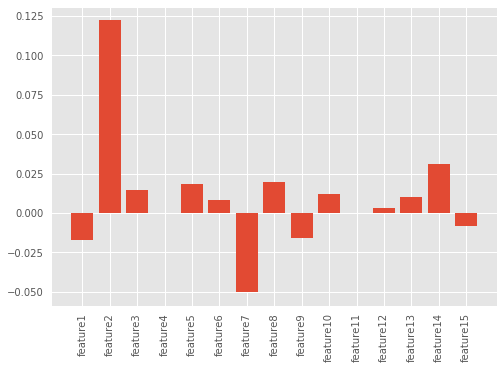

In [34]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v2
Below we have defined another LSTM model which has 3 LSTM layers of all same unit sizes of 30. Last layer is again sigmoid layer.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 30)            5520      
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                496       
Total params: 20,656
Trainable params: 20,656
Non-trainable params: 0
_________________________________________________________________
None


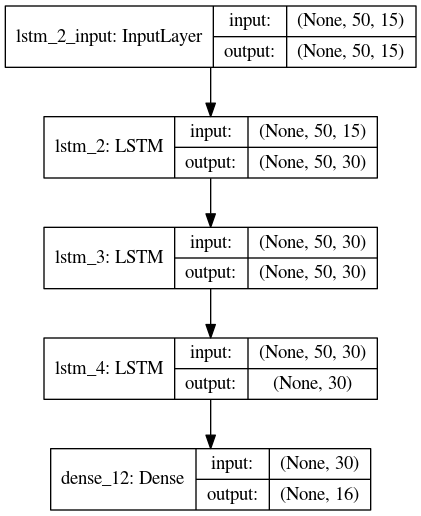

In [35]:
lstm_classif = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=30, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train_one_hot.shape[1], activation='sigmoid')
                ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif2.png', show_shapes=True)
Image.open('lstm_classif2.png')

## Compiling Model

In [36]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [37]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=8, validation_data=(X_test, Y_test_one_hot), verbose=1, shuffle=False)

Train on 2430 samples, validate on 226 samples
Epoch 1/30
2430/2430 [==============================] - 23s 9ms/step - loss: 0.5031 - accuracy: 0.7713 - val_loss: 0.5400 - val_accuracy: 0.7533
Epoch 2/30
2430/2430 [==============================] - 21s 9ms/step - loss: 0.4919 - accuracy: 0.7793 - val_loss: 0.5348 - val_accuracy: 0.7533
Epoch 3/30
2430/2430 [==============================] - 22s 9ms/step - loss: 0.4902 - accuracy: 0.7796 - val_loss: 0.5304 - val_accuracy: 0.7533
Epoch 4/30
2430/2430 [==============================] - 21s 9ms/step - loss: 0.4890 - accuracy: 0.7794 - val_loss: 0.5298 - val_accuracy: 0.7464
Epoch 5/30
2430/2430 [==============================] - 21s 9ms/step - loss: 0.4884 - accuracy: 0.7794 - val_loss: 0.5312 - val_accuracy: 0.7533
Epoch 6/30
2430/2430 [==============================] - 21s 9ms/step - loss: 0.4884 - accuracy: 0.7793 - val_loss: 0.5285 - val_accuracy: 0.7533
Epoch 7/30
2430/2430 [==============================] - 21s 9ms/step - loss: 0.4876

## Visualizing Training Stage Results

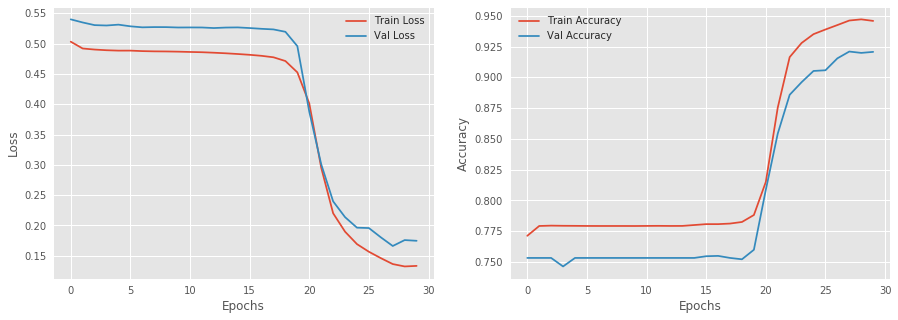

In [38]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [39]:
loss, acc = lstm_classif.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

226/226 [==============================] - 0s 550us/step
Accuracy : 0.921


In [40]:
loss, acc = lstm_classif.evaluate(X_new, Y_new)
print('Accuracy : %.3f'%acc)

2706/2706 [==============================] - 1s 511us/step
Accuracy : 0.938


In [41]:
probs = lstm_classif.predict_proba(X_new)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_cols[i])
    pred_labels.append(l)
    
df4 = copy.deepcopy(data)
df4['Preds'] = np.hstack((['label_down_200']*50, pred_labels))
for i, col in enumerate(target_cols):
    df4[col + '_probs'] = np.hstack((np.zeros(50), probs[:,i]))

## Printing/Plotting Classification Metrics

In [42]:
predictions = lstm_classif.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('LSTMv2' , actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[193   6]
  [  5  22]]

 [[188   5]
  [  4  29]]

 [[183   6]
  [  2  35]]

 [[178   8]
  [  1  39]]

 [[166  11]
  [  7  42]]

 [[148  16]
  [  4  58]]

 [[132  19]
  [  2  73]]

 [[110  25]
  [  0  91]]

 [[ 89  31]
  [  1 105]]

 [[111  22]
  [  1  92]]

 [[129  22]
  [  0  75]]

 [[144  19]
  [  1  62]]

 [[162  17]
  [  1  46]]

 [[176  10]
  [  4  36]]

 [[189   6]
  [  5  26]]

 [[200   3]
  [  2  21]]]


## Visualising Weights

Layer : LSTM : Weights : (15, 120)
Layer : LSTM : Weights : (30, 120)
Layer : LSTM : Weights : (120,)
Layer : Dense : Weights : (30, 120)
Layer : Dense : Bias : (30, 120)


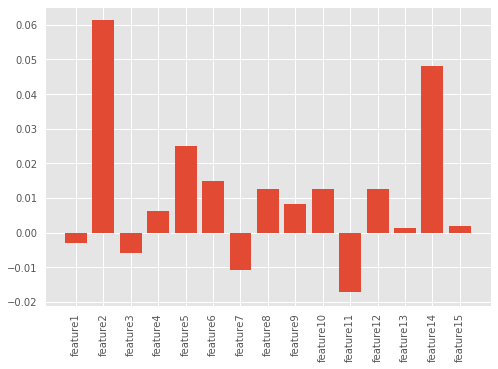

In [43]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

In [44]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('DenseNetv1',df1), ('DenseNetv2',df2), ('LSTMv1', df3), ('LSTMv2', df4)]:
        df1.to_excel(writer, sheet_name= sheet_name)

In [45]:
from IPython.display import FileLink
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx